# Semantische Segmentierung - Beispiel

Dieses Notebook demonstriert die Verwendung von semantischen Segmentierungsmodellen für:
1. Inferenz auf einem einzelnen Bild aus dem ADE20K Datensatz
2. Inferenz auf beliebigen Bildern

Wir verwenden die Hilfsfunktionen aus dem 'eah_segmentation' Paket.


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
from PIL import Image

from eah_segmentation.metrics import evaluate_single_image, run_inference_on_arbitrary_image
from eah_segmentation.ade20k_utils import load_ade20k_dataset
from eah_segmentation.utils import load_model
from eah_segmentation.ade20k_utils import colorize_ade20k_mask


2025-06-13 21:37:04.736885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ Successfully imported ai_edge_litert
✅ Successfully imported ai_edge_litert
✅ Successfully imported ai_edge_litert


In [2]:
# Hilfsfunktion zur Anzeige der Ergebnisse
def display_segmentation_results(results, title="Segmentierungsergebnisse"):
    """Zeigt das Originalbild, die Referenzmaske (falls verfügbar), Vorhersage und Überlagerung an."""
    has_ground_truth = 'true_mask' in results
    n_cols = 4 if has_ground_truth else 3
    plt.figure(figsize=(5*n_cols, 5))
    
    # Originalbild
    plt.subplot(1, n_cols, 1)
    plt.imshow(results['image'])
    plt.title("Originalbild")
    plt.axis('off')
    
    # Konvertiere Bild zu uint8 für Überlagerung
    if results['image'].dtype == np.float32 or results['image'].dtype == np.float64:
        image_uint8 = (results['image'] * 255).astype(np.uint8)
    else:
        image_uint8 = results['image'].copy()
    
    # Stelle sicher, dass das Bild RGB ist
    if len(image_uint8.shape) == 2:
        image_uint8 = cv2.cvtColor(image_uint8, cv2.COLOR_GRAY2RGB)
    elif image_uint8.shape[2] == 4:
        image_uint8 = cv2.cvtColor(image_uint8, cv2.COLOR_RGBA2RGB)
    
    current_col = 2
    
    # Referenzmaske (falls verfügbar)
    if has_ground_truth:
        plt.subplot(1, n_cols, current_col)
        colored_true_mask = colorize_ade20k_mask(results['true_mask'])
        plt.imshow(colored_true_mask)
        plt.title("Referenzmaske")
        plt.axis('off')
        current_col += 1
    
    # Vorhergesagte Maske
    plt.subplot(1, n_cols, current_col)
    colored_pred_mask = colorize_ade20k_mask(results['pred_mask'])
    plt.imshow(colored_pred_mask)
    plt.title("Vorhersage")
    plt.axis('off')
    current_col += 1
    
    # Stelle sicher, dass Masken die gleichen Dimensionen wie das Bild haben
    if image_uint8.shape[:2] != colored_pred_mask.shape[:2]:
        colored_pred_mask = cv2.resize(colored_pred_mask, 
                                     (image_uint8.shape[1], image_uint8.shape[0]),
                                     interpolation=cv2.INTER_NEAREST)
    
    # Erstelle Überlagerung
    plt.subplot(1, n_cols, current_col)
    overlay = cv2.addWeighted(image_uint8, 0.7, colored_pred_mask, 0.3, 0)
    plt.imshow(overlay)
    plt.title("Überlagerung")
    plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.suptitle(title)
    plt.show()


## 1. Modell und Gerät auswählen

Zuerst wählen wir das zu verwendende Gerät und laden eines unserer Segmentierungsmodelle.

### Verfügbare Geräte (DEVICE):
- 'cpu': Standard CPU-Ausführung
- 'coral': Google Coral Edge TPU (falls verfügbar)

### Modelltypen (model_type):
- 'tflite': TensorFlow Lite Modelle (optimiert für mobile/edge Geräte)
- 'keras': Standard Keras/TensorFlow Modelle

### Verfügbare Modelle (MODEL_NAME):

**Auf ADE20K trainierte Modelle:**
- 'segformer': SegFormer B0 (klein und schnell)
- 'deeplabv3plus': DeepLabV3+ mit Edge TPU Optimierung

**Auf Cityscapes trainierte Modelle:**
- 'mosaic': Mosaic (größer und genauer)
- 'deeplabv3edge': DeepLabV3 für Straßenszenen

Die Modelle unterscheiden sich in ihrer Größe, Geschwindigkeit und Genauigkeit:
- SegFormer B0: Kleines, effizientes Modell für schnelle Inferenz, trainiert auf ADE20K
- DeepLabV3+: Optimiert für Edge TPU, gutes Verhältnis von Geschwindigkeit und Genauigkeit, trainiert auf ADE20K
- Mosaic: Größeres Modell mit höherer Genauigkeit für Straßenszenen, trainiert auf Cityscapes
- DeepLabV3 Cityscapes: Speziell für Straßenszenen optimiert, trainiert auf Cityscapes

**Wichtiger Hinweis:** 
Die Modelle 'mosaic' und 'deeplabv3edge' wurden auf dem Cityscapes-Datensatz trainiert, der andere Klassen als ADE20K enthält. Daher können die Segmentierungsfarben in der Visualisierung für diese Modelle von den erwarteten Farben abweichen, da sie auf das ADE20K-Farbschema abgebildet werden.

Wählen Sie die Kombination basierend auf Ihren Anforderungen aus:
- Für allgemeine Szenen: Verwenden Sie die ADE20K-trainierten Modelle
- Für Straßenszenen: Verwenden Sie die Cityscapes-trainierten Modelle


In [3]:
# Gerät und Modell auswählen
DEVICE = 'cpu'      # Optionen: 'cpu' oder 'coral' (für Google Coral Edge TPU)
MODEL_NAME = 'deeplabv3plus'  # Optionen: 'segformer', 'deeplabv3plus', 'mosaic', 'deeplabv3edge'
MODEL_TYPE = 'tflite'    # Optionen: 'tflite' oder 'keras'

# Modell laden
print(f"🔄 Lade {MODEL_NAME} Modell ({MODEL_TYPE}) für {DEVICE}...")
model, load_time = load_model(MODEL_NAME, MODEL_TYPE, device=DEVICE)
print(f"✅ {MODEL_NAME} Modell erfolgreich auf {DEVICE.upper()} geladen (Ladezeit: {load_time:.3f}s)")

# Hinweis zu den Modelloptionen ausgeben
print("\nℹ️  Verfügbare Optionen:")
print("   DEVICE: 'cpu', 'coral'")
print("   MODEL_NAME: 'segformer', 'deeplabv3plus', 'mosaic', 'deeplabv3edge'")
print("   MODEL_TYPE: 'tflite', 'keras'")


🔄 Lade deeplabv3plus Modell (tflite) für cpu...

🚀 Loading deeplabv3plus (tflite) for cpu...
📥 Loading TFLite model from /Users/juergen/Documents/Bewerbung/FH-Jena/code/lecturematerial-semantics/models/deeplabv3plus_edgetpu/tflite/1.tflite
⏱️  Model loading time: 0.146 seconds
✅ deeplabv3plus Modell erfolgreich auf CPU geladen (Ladezeit: 0.146s)

ℹ️  Verfügbare Optionen:
   DEVICE: 'cpu', 'coral'
   MODEL_NAME: 'segformer', 'deeplabv3plus', 'mosaic', 'deeplabv3edge'
   MODEL_TYPE: 'tflite', 'keras'


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## 2. Beispiel 1: Einzelnes Bild aus dem Datensatz

Lassen Sie uns die Inferenz auf einem einzelnen Bild aus dem ADE20K Datensatz durchführen.
Sie können den `image_index` unten ändern, um verschiedene Bilder aus dem Datensatz zu testen (0-1999).


📥 Lade ADE20K Datensatz...
📥 Loading ADE20K dataset...
Found 2000 validation images
🔄 Führe Inferenz auf Bild 2 durch...

📊 Ground Truth Classes:
Class ID | Class Name | Pixel Count | Percentage
-------------------------------------------------------
       0 | background           |       4472 |     1.71%
       1 | wall                 |       6342 |     2.42%
       2 | building             |      19765 |     7.54%
       3 | sky                  |      60562 |    23.10%
       5 | tree                 |       4473 |     1.71%
       7 | road                 |      65646 |    25.04%
      12 | sidewalk             |      49190 |    18.76%
      21 | car                  |       5120 |     1.95%
      44 | signboard            |        321 |     0.12%
      81 | bus                  |       3700 |     1.41%
      88 | streetlight          |        467 |     0.18%
      97 | escalator            |      38556 |    14.71%
     103 | van                  |       3530 |     1.35%

📊 Input

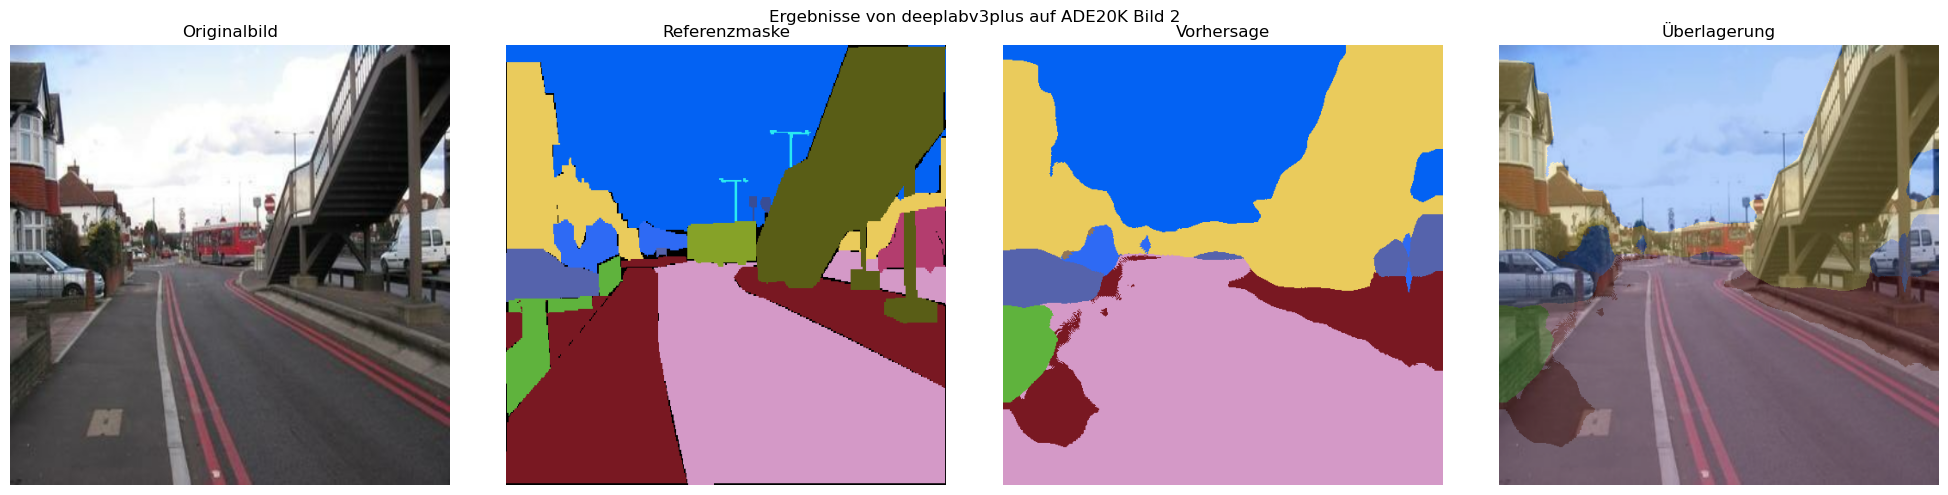

⏱️ Inferenzzeit: 449.48ms

📊 Vorhergesagte Klassen:
  Klasse 1: 5410 Pixel (2.1%)
  Klasse 2: 65120 Pixel (24.8%)
  Klasse 3: 61237 Pixel (23.4%)
  Klasse 5: 2504 Pixel (1.0%)
  Klasse 7: 95342 Pixel (36.4%)
  Klasse 12: 21962 Pixel (8.4%)
  Klasse 18: 130 Pixel (0.0%)
  Klasse 21: 10439 Pixel (4.0%)


In [4]:
# Bildindex auswählen (0-1999)
image_index = 2  # Ändern Sie diese Zahl, um ein anderes Bild auszuwählen

try:
    # Datensatz laden
    print("📥 Lade ADE20K Datensatz...")
    dataset = load_ade20k_dataset('../datasets')
    
    # Ausgewähltes Bild laden
    images, masks = next(iter(dataset.skip(image_index).take(1)))
    
    # Bild verarbeiten (Batch-Dimension entfernen)
    image = images[0].numpy()
    mask = masks[0].numpy()
    
    # Inferenz durchführen
    print(f"🔄 Führe Inferenz auf Bild {image_index} durch...")
    results = evaluate_single_image(model, image, true_mask=mask, model_name=MODEL_NAME)
    
    # Ergebnisse anzeigen
    display_segmentation_results(results, f"Ergebnisse von {MODEL_NAME} auf ADE20K Bild {image_index}")
    
except tf.errors.OutOfRangeError:
    print("❌ Datensatz ist leer oder Index außerhalb des gültigen Bereichs.")
    print("   Bitte stellen Sie sicher, dass der ADE20K Datensatz im Verzeichnis 'datasets' verfügbar ist.")
except Exception as e:
    print(f"❌ Fehler beim Laden des Datensatzes oder bei der Inferenz: {str(e)}")
    print("   Bitte stellen Sie sicher, dass der ADE20K Datensatz im Verzeichnis 'datasets' verfügbar ist")


## 3. Beispiel 2: Beliebiges Bild

Jetzt können wir die Inferenz auf einem beliebigen Bild durchführen.
Verwenden Sie den Upload-Button unten, um ein eigenes Bild hochzuladen und zu segmentieren.

Unterstützte Bildformate:
- JPEG/JPG
- PNG
- BMP
- GIF (erstes Frame)

Das Bild wird automatisch auf die richtige Größe skaliert.


In [6]:
def create_upload_widget():
    """Create and display an image upload widget with output area"""
    # Create output widget for displaying results
    output = widgets.Output()
    
    # Create upload widget
    upload = widgets.FileUpload(
        accept='image/*',  # Accept all image types
        multiple=False,    # Only allow single file selection
        description='Select Image',
        button_style='primary',
        layout=widgets.Layout(width='auto', height='auto')
    )
    
    def process_uploaded_image(change):
        """Process the uploaded image and run inference"""
        if not upload.value:
            return
            
        with output:
            # Clear previous output
            output.clear_output(wait=True)
            
            try:
                # Get the uploaded file data
                content = next(iter(upload.value))['content']  # Get content of first file
                
                # Convert to numpy array
                image = np.array(Image.open(io.BytesIO(content)))
                
                # Store original size for later
                original_height, original_width = image.shape[:2]
                
                # Convert RGBA to RGB if needed
                if len(image.shape) == 3 and image.shape[2] == 4:
                    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
                elif len(image.shape) == 2:
                    # Convert grayscale to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                
                # Resize to 512x512 (model's expected input size)
                image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
                
                # Normalize image to [0,1] range
                image = image.astype(np.float32) / 255.0
                
                print(f"Processing image (resized from {original_width}x{original_height} to 512x512)")
                
                # Run inference
                results = evaluate_single_image(model, image, model_name=MODEL_NAME)
                
                # Display results
                display_segmentation_results(results, f"Results from {MODEL_NAME} on uploaded image")
                
            except Exception as e:
                print(f"Error processing image: {str(e)}")
                print("Please make sure to upload a valid image file")
            
            # Reset the upload widget by creating a new instance
            upload.value = ()  # This clears the selection
    
    # Register the callback
    upload.observe(process_uploaded_image, names='value')
    
    # Create a vertical box layout
    vbox = widgets.VBox([
        widgets.HTML("<h3>Upload an image for segmentation:</h3>"),
        upload,
        output
    ])
    
    # Display the widget
    display(vbox)

# Create and display the widget
create_upload_widget()